In [1]:
# Install library for AFM data Rheology Analysis
%pip uninstall pyafmrheo --yes
%pip install git+https://github.com/jlopezalo/pyafmrheo.git

Found existing installation: pyafmrheo 0.0.1
Uninstalling pyafmrheo-0.0.1:
  Successfully uninstalled pyafmrheo-0.0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/jlopezalo/pyafmrheo.git to /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-66il5heg
  Running command git clone -q https://github.com/jlopezalo/pyafmrheo.git /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-req-build-66il5heg
  Created wheel for pyafmrheo: filename=pyafmrheo-0.0.1-py3-none-any.whl size=32838 sha256=70e4812c76b434bdc7391014ab7a8df8da81485299ca20974e613018dc37e96b
  Stored in directory: /private/var/folders/4k/ps22fmxj3gx6vls78t2p63wh0000gn/T/pip-ephem-wheel-cache-ailg2b9s/wheels/fb/66/18/3e93b45c845b0d7b83ded1e127a1c127820d070ce5b71dece4
Successfully built pyafmrheo
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries we will need
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model, Parameters

# Get file reader from library
from pyafmreader import loadfile

# Get data analysis tools
from pyafmrheo.utils.force_curves import *
from pyafmrheo.models.hertz import HertzModel
from pyafmrheo.models.ting import TingModel

In [3]:
# Define global variables
# file_path = '/Users/javierlopez/Documents/Marseille/05-11-2021/E/map-data-2021.11.05-15.41.45.699.jpk-force-map'
file_path = '/Users/javierlopez/Documents/testingPyFM/map-data-2021.12.06-19.40.19.296.jpk-force-map'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200903_Egel2.0_00023.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/20200904_Egel4-Z1.0_00025.spm'
# file_path = '/Users/javierlopez/Documents/pyafmreader/tests/testfiles/08171528.0_00001.pfc'
# Shapes available: paraboloid, pyramid
indenter_shape = "paraboloid"
# indenter_shape = "pyramid"
tip_parameter = 30 * 1e-9 # meters
# tip_parameter = 35 # degrees
# Poisson ratio
poisson_ratio = 0.5
# If None it will use the deflection sensitivity from the file
deflection_sensitivity = None # m/V
# If None it will use the spring constant from the file
spring_constant = None # N/m
# General plotting params
plt.rcParams["figure.figsize"] = (10,5)
vdrag = 0

In [4]:
def run_analysis(file, curve_idx):
    force_curve = file.getcurve(curve_idx)
    extend_segments = force_curve.extend_segments
    pause_segments = force_curve.pause_segments
    modulation_segments = force_curve.modulation_segments
    retract_segments = force_curve.retract_segments
    force_curve_segments = force_curve.get_segments()
    force_curve.preprocess_force_curve(deflection_sensitivity, height_channel)
    # Get approach, first extend segment
    first_exted_seg_id, first_ext_seg = extend_segments[0]
    # Get retract, last retract segment
    last_ret_seg_id, last_ret_seg = retract_segments[-1]
    # Shift height
    force_curve.shift_height()
    v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    t_offset = np.abs(first_ext_seg.zheight[-1] - last_ret_seg.zheight[0]) / v0t
    dt = np.abs(first_ext_seg.time[1] - first_ext_seg.time[0])
    if t_offset > 2 * dt:
        last_ret_seg.time = last_ret_seg.time + t_offset
    app_height = first_ext_seg.zheight
    app_deflection = first_ext_seg.vdeflection
    ret_height = last_ret_seg.zheight
    ret_deflection = last_ret_seg.vdeflection
    # Find initial PoC, you may get some warnings.
    poc = get_poc_RoV_method(app_height, app_deflection, win_size=50)
    # Hertz fit
    first_ext_seg.get_force_vs_indentation(poc, spring_constant)
    app_indentation, app_force = first_ext_seg.indentation, first_ext_seg.force

    # plt.plot(app_height - poc[0], app_deflection*spring_constant)
    # plt.show()

    # app_indentation = app_height - poc[0]
    # app_force = app_deflection*spring_constant

    hertzmodel = HertzModel(indenter_shape, tip_parameter)
    hertzmodel.fit(app_indentation, app_force)

    hertzmodel.fit_report()

    hertz_E0 = hertzmodel.E0
    hertz_d0 = hertzmodel.delta0
    hertz_f0 = hertzmodel.f0
    
    # Get force vs indentation for all segments
    poc[0] += hertz_d0

    # Get indentation and force
    first_ext_seg.get_force_vs_indentation(poc, spring_constant)
    app_indentation, app_force, app_time = first_ext_seg.indentation, first_ext_seg.force, first_ext_seg.time
    last_ret_seg.get_force_vs_indentation(poc, spring_constant)
    ret_indentation, ret_force, ret_time = last_ret_seg.indentation, last_ret_seg.force, last_ret_seg.time
    
    idx_tc = (np.abs(app_indentation - 0)).argmin()
    t0 = app_time[-1]
    indentation = np.r_[app_indentation, ret_indentation]
    time = np.r_[app_time, ret_time + t0]
    force = np.r_[app_force, ret_force]
    fit_mask = indentation > (-1 * 1e-6)
    tc = time[idx_tc]
    ind_fit = indentation[fit_mask]
    force_fit = force[fit_mask]
    force_fit = force_fit - force_fit[0]
    time_fit = time[fit_mask]
    tc_fit = tc-time_fit[0]
    time_fit = time_fit - time_fit[0]
    tm = time_fit[np.argmax(force_fit)]
    idx_tm = np.argmax(force_fit)
    
    downfactor=int(len(time_fit)/1000)
    # downfactor=1
    idxDown = list(range(0, len(time_fit), downfactor))
    idx_tm = np.argmax(force_fit[idxDown])
    f0idx = np.where(time_fit==tc_fit)[0]
    # vdrag = 1*1e3*1e-9
    vdrag = 0
    F0_init=force_fit[f0idx]
    
    tc_max = tc_fit+downfactor/(1/(time_fit[1]-time_fit[0]))*10
    tc_min = tc_fit-downfactor/(1/(time_fit[1]-time_fit[0]))*10
    f0_max = F0_init+100e-12
    f0_min = F0_init-100e-12
    
    ting_model_num = TingModel(indenter_shape, tip_parameter, 'analytical')
    smooth_w = 1
    t0 = 1
    modelFt = 'analytical'
    v0t = np.abs(first_ext_seg.zheight.min() - first_ext_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    v0r = np.abs(last_ret_seg.zheight.min() - last_ret_seg.zheight.max())/first_ext_seg.segment_metadata['duration']
    # modelFt = 'numerical'
    idx_tm = np.argmax(force_fit[idxDown])
    model_for_fit = lambda time, E0, tc, betaE, F0: ting_model_num.model(time, E0, tc, betaE, F0, t0, force_fit[idxDown], ind_fit[idxDown], modelFt, vdrag, idx_tm, smooth_w, v0t, v0r)
    model = Model(model_for_fit)
    print(f'parameter names: {model.param_names}')
    print(f'independent variables: {model.independent_vars}')
    params = Parameters()
    params.add('E0', value=hertz_E0, min=hertz_E0/1000, max=np.inf)
    params.add('tc', value=tc_fit, min=tc_min, max=tc_max)
    params.add('betaE', value=0.25, min=0.01, max=0.49)
    params.add('F0', value=F0_init, min=f0_min, max=f0_max)

    result = model.fit(force_fit[idxDown], params, time=time_fit[idxDown])
    
    for param, value in result.best_values.items():
        print(f'{param}:{value}')
    
    # f0 = result.best_values['F0']
    
    plt.plot(ind_fit[idxDown], force_fit[idxDown], 'o')
    # plt.plot(time_fit[idxDown], result.init_fit, '--', label='initial fit')
    plt.plot(ind_fit[idxDown], result.best_fit, '-', label='best fit')
    plt.legend()
    plt.show()

In [5]:
file = loadfile(file_path)
filemetadata = file.filemetadata
# n = filemetadata.get('Entry_tot_nb_curve')
# n = 1
n = [0, 2020, 2148, 2212, 2276]
closed_loop = filemetadata.get('z_closed_loop')
file_deflection_sensitivity = filemetadata.get('defl_sens_nmbyV') #nm/V
file_spring_constant = filemetadata.get('spring_const_Nbym') #N/m
height_channel = filemetadata.get('height_channel_key')

if not deflection_sensitivity: deflection_sensitivity = file_deflection_sensitivity / 1e9 #m/V
if not spring_constant: spring_constant = file_spring_constant

In [6]:
# for curve_idx in range(n):
    # run_analysis(file, curve_idx)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/lib/python3.8/site-packages/pyafmrheo/models/hertz.py:157: RuntimeWarning: divide by zero encountered in divide
  a = (self.get_residuals(indentation, force, sample_height)**2/force)



        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: 6.21905413149089e-08

        E0: 30957.945347277837

        f0: 6.359472688440074e-11

        slope: None

        # Fit metrics
        MAE: 4.584305438464996e-27

        MSE: 3.708021335501817e-21

        RMSE: 6.089352457775635e-11

        Rsq: 0.1793934758490231

        Chisq: -4.254765367761143e-07

        RedChisq: -1.4182551225870477e-07

        
parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']
E0:73722.28206920181
tc:0.005104999999999959
betaE:0.02749664330091485
F0:[-4.04235755e-11]


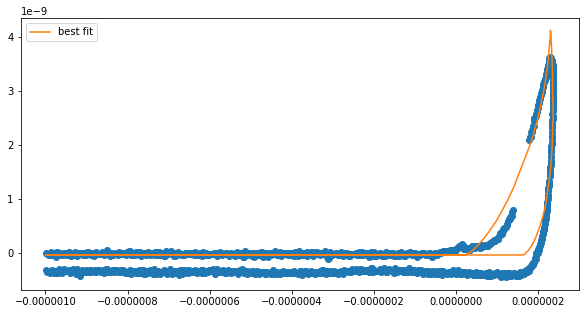


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: -5.6314799438587946e-08

        E0: 2434.871299868564

        f0: -2.41371357397919e-10

        slope: None

        # Fit metrics
        MAE: 9.225404444736594e-22

        MSE: 2.015781604782444e-20

        RMSE: 1.419782238507879e-10

        Rsq: 0.4724976422660452

        Chisq: -5.90760366622804e-07

        RedChisq: -1.9692012220760133e-07

        
parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']
E0:197.94932079384472
tc:0.004699999999999982
betaE:0.32164418504377873
F0:[1.06500575e-10]


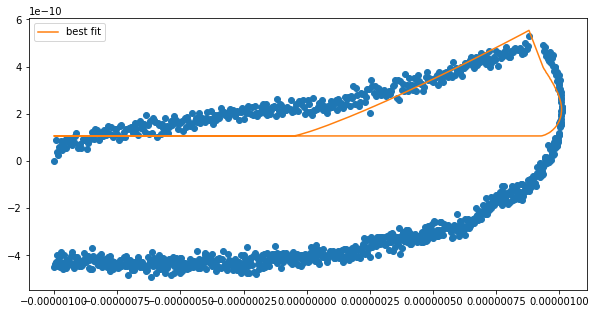


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: -3.937223294444783e-07

        E0: 485.58324978125034

        f0: 2.9762068348289975e-11

        slope: None

        # Fit metrics
        MAE: -7.271829474984123e-20

        MSE: 2.3169827887565846e-21

        RMSE: 4.813504740577893e-11

        Rsq: 0.9409224795476259

        Chisq: -2.7178146157554892e-08

        RedChisq: -9.059382052518297e-09

        
parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']
E0:77.60671339355615
tc:0.004760016054700898
betaE:0.3523278049483815
F0:[-4.39959378e-11]


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


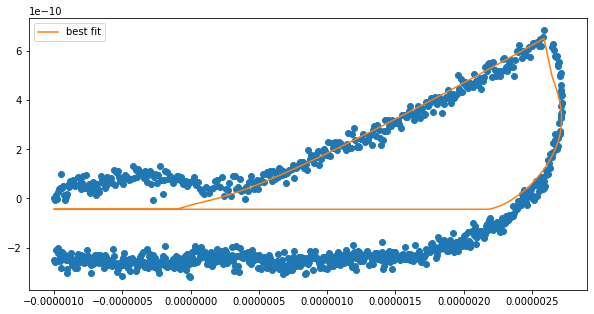


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: 1.7092663478278068e-07

        E0: 6205.765777998399

        f0: 1.110223001667667e-10

        slope: None

        # Fit metrics
        MAE: -1.568616702083497e-22

        MSE: 3.3856867648876356e-21

        RMSE: 5.818665452565249e-11

        Rsq: 0.4104629865610814

        Chisq: 3.6470041223206923e-07

        RedChisq: 1.2156680407735642e-07

        
parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']
E0:3643.933504337871
tc:0.0051550000000001525
betaE:0.17262065868462909
F0:[-5.50584685e-11]


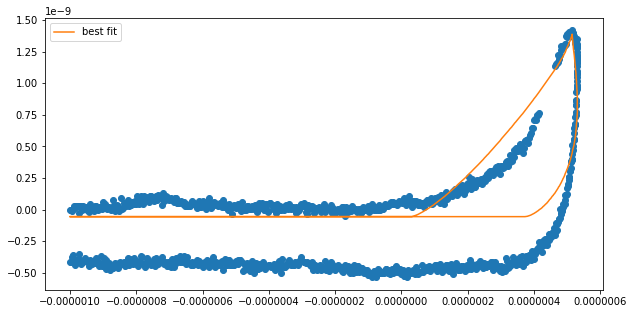


        # Fit parameters
        Indenter shape: paraboloid

        Tip paraneter: 3.0000000000000004e-08

        BEC Model: None

        Number of free parameters: 3

        delta0: -4.35694953654004e-07

        E0: 504.69171316052694

        f0: -6.010089663318033e-11

        slope: None

        # Fit metrics
        MAE: -4.717450887716382e-27

        MSE: 2.1138435140984942e-21

        RMSE: 4.597655396067102e-11

        Rsq: 0.9482524154203431

        Chisq: -1.132553136171104e-07

        RedChisq: -3.775177120570346e-08

        
parameter names: ['E0', 'tc', 'betaE', 'F0']
independent variables: ['time']
E0:58.73895469930632
tc:0.003875007635955628
betaE:0.3959371133917608
F0:[-1.26550074e-10]


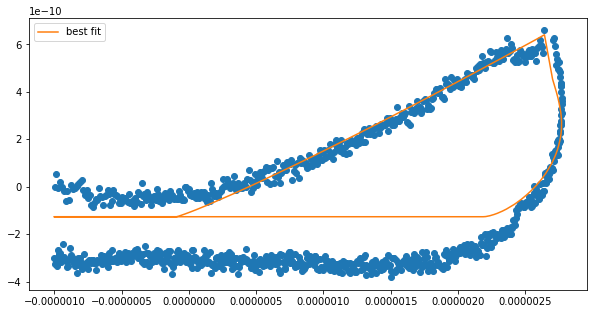

In [7]:
for curve_idx in n:
    run_analysis(file, curve_idx)